# Group 3 Final Project Technical Notebook

Name(s): Dominic Fanucchi, Daniel Grant, Isaack Karanja   
Date:    February 26, 2024

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import pandas as pd
import random

In [ ]:
# Path to CSV files
path_to_files = r'G:/development/USD/aai_530/aai-530_group3/citypulse_traffic_raw_data_surrey_feb_jun_2014/traffic_feb_june/*.csv'

# Set the maximum number of rows for the combined subset
max_rows = 1000000
current_rows = 0

# Set the random seed for reproducibility
random.seed(42)

# Create an empty DataFrame for the combined subset
combined_subset_data = pd.DataFrame()

# Loop through each CSV file, read its data, and take a random subset
for file_path in glob.glob(path_to_files):
    # Read CSV file into a DataFrame
    file_data = pd.read_csv(file_path)

    # Take a subset of the data for EDA (adjust the limit as needed)
    file_subset_data = file_data.sample(n=1000, random_state=42)

    # Check if adding the current subset exceeds the maximum rows limit
    if current_rows + len(file_subset_data) <= max_rows:
        # Concatenate the subset from the current file into the overall subset DataFrame
        combined_subset_data = pd.concat([combined_subset_data, file_subset_data], ignore_index=True)
        current_rows += len(file_subset_data)

        # Print the current number of rows after processing each file
        # print(f'Rows after processing {file_path}: {current_rows}')
    else:
        # Break the loop if the limit is reached
        break

# Print some debugging information
print(f'Final rows: {current_rows}')
print(f'DataFrame shape: {combined_subset_data.shape}')

# Save the combined subset DataFrame to a new CSV file
combined_subset_data.to_csv(r'G:/development/USD/aai_530/aai-530_group3/combined_subset_traffic_data.csv', index=False)


In [ ]:
df = pd.read_csv('combined_subset_traffic_data.csv')

In [ ]:
df.head()

In [ ]:
df.describe()

In [ ]:
df.dtypes

In [ ]:
# view first 10 rows of the column
time = df['TIMESTAMP'].head(10)
print(time)

In [ ]:
# 
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'].str.replace('T', ' '), format='%Y-%m-%d %H:%M:%S')

In [ ]:
# print updated DataFrame
print(df.head())

In [ ]:
# print updated dtypes
df.dtypes

In [ ]:
df.isna().sum().plot.bar()

In [ ]:
# df.plot('TIMESTAMP', ['avgMeasuredTime',	'avgSpeed',	'extID',	'medianMeasuredTime',	'vehicleCount',	'_id',	'REPORT_ID'], subplots=True, figsize=(20,15))
df.plot('TIMESTAMP', ['avgMeasuredTime', 'avgSpeed', 'medianMeasuredTime', 'vehicleCount'], subplots=True, figsize=(20,15))

In [ ]:
# df_avg = df.groupby(pd.Grouper(key = 'TIMESTAMP', freq='1M')).mean()

numeric_columns = df.select_dtypes(include='number').columns
df_avg = df.groupby(pd.Grouper(key='TIMESTAMP', freq='1D'))[numeric_columns].mean()

In [ ]:
df_avg.plot(y=['avgMeasuredTime', 'avgSpeed', 'medianMeasuredTime', 'vehicleCount'], use_index=True, subplots=True, figsize=(20,15))

In [ ]:
axes = pd.plotting.scatter_matrix(df[['avgMeasuredTime', 'avgSpeed', 'medianMeasuredTime', 'vehicleCount']], alpha=0.5,figsize =(10,10))
corr = df[['avgMeasuredTime', 'avgSpeed', 'medianMeasuredTime', 'vehicleCount']].corr(method = 'spearman').to_numpy() #nonlinear
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
plt.show()


In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

In [ ]:
df['unix'] = df['TIMESTAMP'].apply(lambda x:int(x.timestamp()))

In [ ]:
df = df.sort_values(by='TIMESTAMP')
df.head(10)
# Calculate the time differences between consecutive timestamps
time_diff = df['TIMESTAMP'].diff()

# Compute the mean time difference
average_time_difference = time_diff.mean().total_seconds()

# Print the result
print(f"Average time difference: {average_time_difference}")

In [ ]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.vehicleCount)

ph = 5 * 60 #5 minutes
ph_index = round(ph/average_time_difference) #ph/data resolution (how many timesteps is our ph?)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 50000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)


In [ ]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)


    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k] ** k
    weights = np.flip(weights, 0)

    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_
    # print(f'm_tmp: {m_tmp.shape}, q_tmp: {q_tmp.shape}')
    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[ns-1,0] + ph
    yp = m_tmp * tp + q_tmp

    # print(f'yp: {yp.shape}')

    tp_pred[i-2] = tp
    yp_pred[i-2] = yp[0,0] # resolve deprecation warning: extract the scalar␣value from the np.array 'yp' before assignment

# mu_weight = mu ** n_s
# print(mu_weight)

In [ ]:
fig, ax = plt.subplots(figsize=(20,15))
fig.suptitle('Vehicle Count Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))

ax.plot(tp_pred, yp_pred, label='Predicted Value')
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='Traffic data')

ax.set_xlabel('time (unix)')
ax.set_ylabel('count')
ax.legend()
plt.show()


In [ ]:
#Plot first 500 data points/predictions
fig, ax = plt.subplots(figsize=(20,15))
fig.suptitle('Vehicle Count Prediction (First 200)', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))

ax.plot(tp_pred[0:500], yp_pred[0:500], label='Predicted Value')
ax.plot(ts.iloc[0:500,0], ys.iloc[0:500,0], label='Traffic data')


ax.set_xlabel('time (unix)')
ax.set_ylabel('count')
ax.legend()
plt.show()

In [ ]:
#Plot last 500 data points/predictions
fig, ax = plt.subplots(figsize=(20,15))
fig.suptitle('Vehicle Count Prediction (Last 500)', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))

ax.plot(tp_pred[-500:], yp_pred[-500:], label='Predicted Value')
ax.plot(ts.iloc[n_s-500:n_s,0], ys.iloc[n_s-500:n_s,0], label='Traffic data')


ax.set_xlabel('time (unix)')
ax.set_ylabel('count')
ax.legend()
plt.show()

In [ ]:
#Calculate MSE of predictions
print("MSE is", mse(ys['vehicleCount'][ph_index:50000+ph_index-1],yp_pred))

Rewriting Linear Regression Model with new data subset.Trying to make improvements and save off prediction dataset to be used in Tableau dashboard.

In [3]:
# importing huggingface package
from datasets import load_dataset
#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

c:\Users\HomeBase\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dataset = load_dataset(
    "mugithi/down_sampled_file_traffic_dataset", 
    data_files={
        "train": "data/train-00000-of-00001.parquet", 
        "test": "data/test-00000-of-00001.parquet"
    }
)

In [5]:
dataset.shape

{'train': (800000, 10), 'test': (200000, 10)}

In [6]:
# converting the huggingface parquet files into Pandas DataFrames
df = dataset['train'].to_pandas()
df_test = dataset['test'].to_pandas()

Check to see everything loaded in correctly. The data has already been cleaned, and EDA has been done in a seperate notebook.

In [7]:
print(df.head())
print("*" * 80)
print(df.dtypes)

   avgSpeed  junction            TIMESTAMP  vehicleCount  Year  Month  \
0        41      1041  2014-02-13 11:30:00             4  2014      2   
1         0       744  2014-02-13 11:30:00             0  2014      2   
2        35       652  2014-02-13 11:30:00             0  2014      2   
3        50       749  2014-02-13 11:30:00            11  2014      2   
4        50       759  2014-02-13 11:30:00            15  2014      2   

   Date_no  Hour       Day             unix  
0       13    11  Thursday 1392291000.00000  
1       13    11  Thursday 1392291000.00000  
2       13    11  Thursday 1392291000.00000  
3       13    11  Thursday 1392291000.00000  
4       13    11  Thursday 1392291000.00000  
********************************************************************************
avgSpeed          int64
junction          int64
TIMESTAMP        object
vehicleCount      int64
Year              int64
Month             int64
Date_no           int64
Hour              int64
Day         

After scrolling through the dataset on huggingface, the TIMESTAMP column shows readings every 5 minutes. This should simplify some aspects of our time series analysis.
- Convert TIMESTAMP and unix to dataetime objects.

In [8]:
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df_test['TIMESTAMP'] = pd.to_datetime(df_test['TIMESTAMP'])
df.dtypes

avgSpeed                 int64
junction                 int64
TIMESTAMP       datetime64[ns]
vehicleCount             int64
Year                     int64
Month                    int64
Date_no                  int64
Hour                     int64
Day                     object
unix                   float64
dtype: object

In [9]:
desc = df.describe(include='all')
desc

avgSpeed     junction                      TIMESTAMP  vehicleCount  \
count  800000.00000 800000.00000                         800000  800000.00000   
unique          NaN          NaN                            NaN           NaN   
top             NaN          NaN                            NaN           NaN   
freq            NaN          NaN                            NaN           NaN   
mean       43.64888    827.68204  2014-03-31 05:26:11.040750080       3.25050   
min         0.00000    610.00000            2014-02-13 11:30:00       0.00000   
25%        29.00000    716.00000            2014-03-07 16:20:00       0.00000   
50%        43.00000    824.00000            2014-04-01 06:40:00       1.00000   
75%        57.00000    938.00000            2014-04-23 03:35:00       4.00000   
max       149.00000   1058.00000            2014-05-15 16:30:00      92.00000   
std        22.10179    128.82472                            NaN       6.04203   

               Year        Month      Date_no         Hour       Day  \
count  800000.00000 800000.00000 800000.00000 800000.00000    800000   
unique          NaN          NaN          NaN          NaN         7   
top             NaN          NaN          NaN          NaN  Thursday   
freq            NaN          NaN          NaN          NaN    117111   
mean     2014.00000      3.49053     15.16852     11.25824       NaN   
min      2014.00000      2.00000      1.00000      0.00000       NaN   
25%      2014.00000      3.00000      8.00000      6.00000       NaN   
50%      2014.00000      4.00000     15.00000     11.00000       NaN   
75%      2014.00000      4.00000     22.00000     17.00000       NaN   
max      2014.00000      5.00000     31.00000     23.00000       NaN   
std         0.00000      0.96177      8.51710      6.70249       NaN   

                   unix  
count      800000.00000  
unique              NaN  
top                 NaN  
freq                NaN  
mean   1396243571.04075  
min    1392291000.00000  
25%    1394209200.00000  
50%    1396334400.00000  
75%    1398224100.00000  
max    1400171400.00000  
std       2293769.99330

<Axes: >

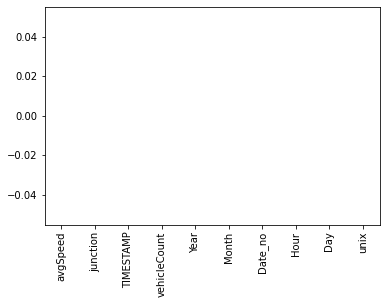

In [10]:
df.isna().sum().plot.bar()

We not have any missing data, which we should expect, since we are working with a cleaned dataset. Now, we can move on visualizing our data.

<Axes: xlabel='TIMESTAMP'>

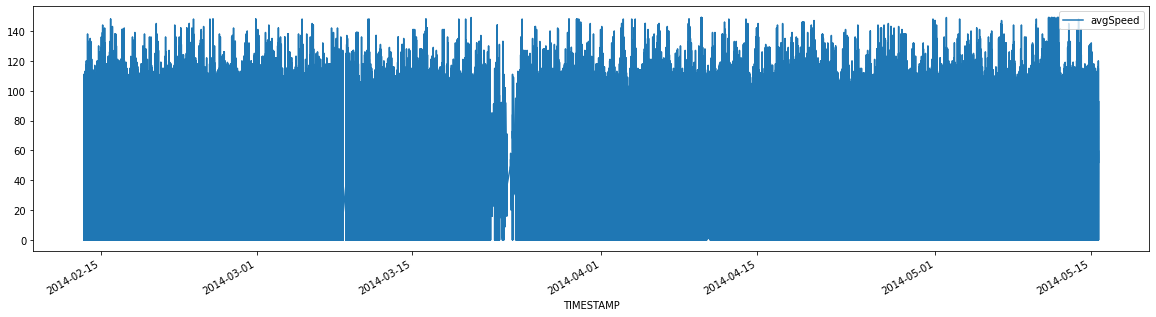

In [11]:
df.plot('TIMESTAMP', ['avgSpeed'], figsize=(20,5))

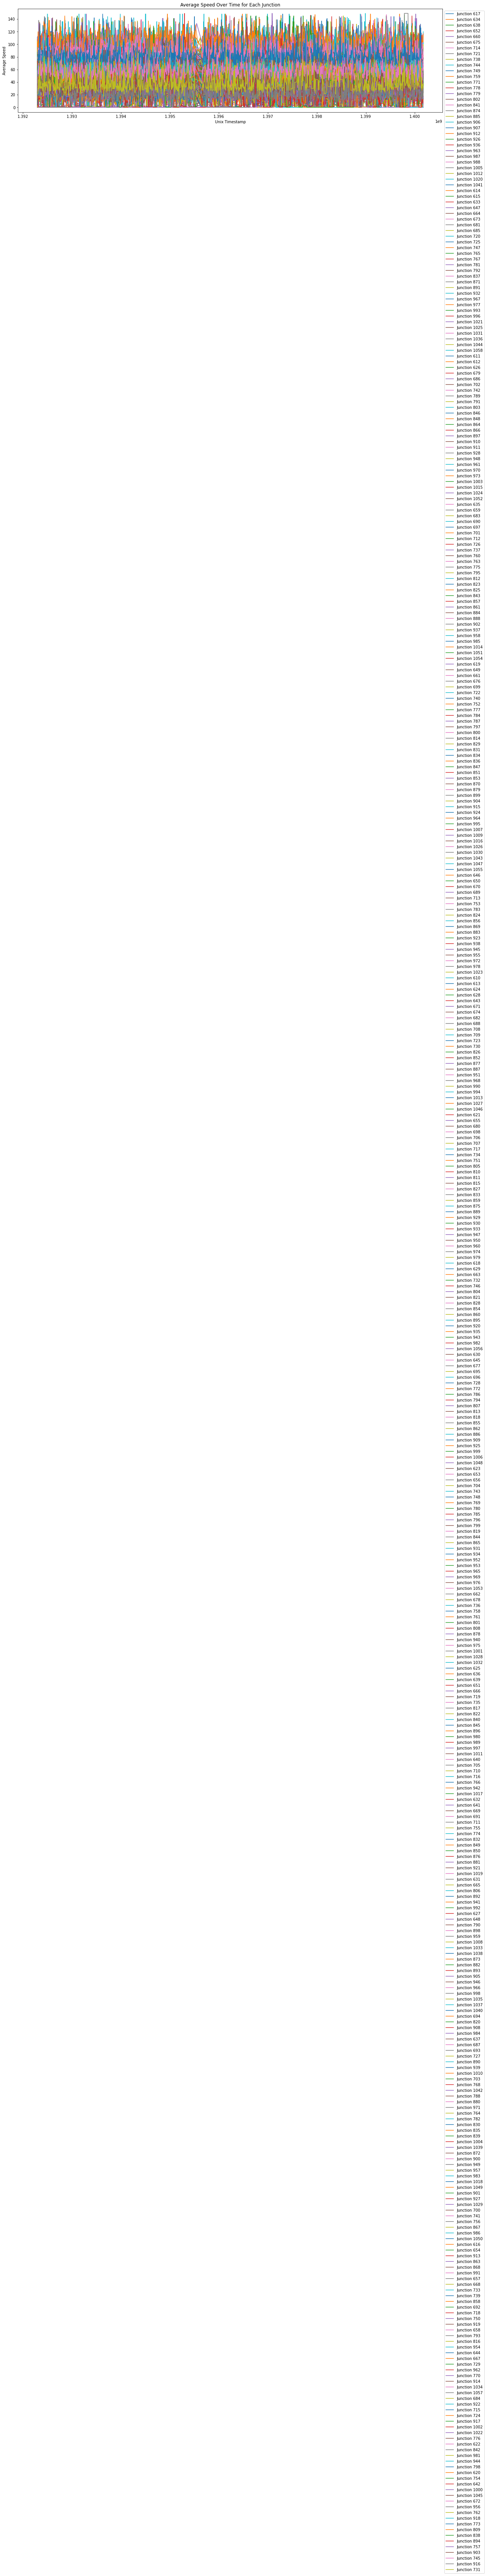

In [12]:
# Group by 'unix' and 'junction' and calculate the mean of 'avgSpeed' for each junction and timestamp
grouped_data = df.groupby(['unix', 'junction'])['avgSpeed'].mean().reset_index()

# Plot average speed for each junction
plt.figure(figsize=(20, 5))

# Iterate over unique junctions and plot each one
for junction in grouped_data['junction'].unique():
    junction_data = grouped_data[grouped_data['junction'] == junction]
    plt.plot(junction_data['unix'], junction_data['avgSpeed'], label=f'Junction {junction}')

# Set labels and legend
plt.xlabel('Unix Timestamp')
plt.ylabel('Average Speed')
plt.title('Average Speed Over Time for Each Junction')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

This is extremely noise and cannot discerne any useful information from it. I will be doing aggregate time intervals as well as subplots so help reduce some of the noise.

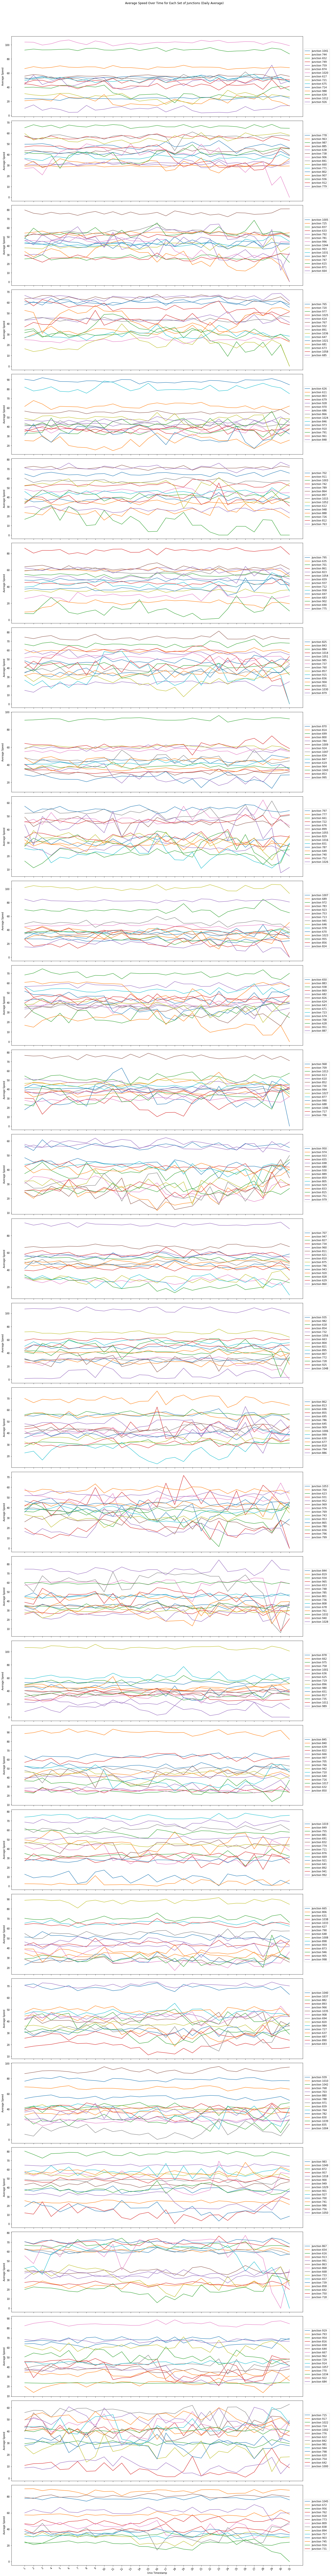

In [13]:
# Count the number of unique junctions
unique_junctions = df['junction'].unique()
num_junctions = len(unique_junctions)
# print(num_junctions)

# Determine the number of subplots (let's say 5 subplots for demonstration)
num_subplots = min(num_junctions, 30)
# print(num_subplots)

# Calculate the number of junctions per subplot
junctions_per_subplot = int(np.ceil(num_junctions / num_subplots))
# print(junctions_per_subplot)

# Create subplots
fig, axes = plt.subplots(num_subplots, 1, figsize=(20, 5 * num_subplots), sharex=True)

# Iterate over subplots and plot each set of junctions
for i in range(num_subplots):
    start_idx = i * junctions_per_subplot
    end_idx = (i + 1) * junctions_per_subplot

    # Plot for the current set of junctions
    for junction in unique_junctions[start_idx:end_idx]:
        junction_data = df[df['junction'] == junction]
        # Group by 'Date_no' and calculate the mean of 'avgSpeed' for each day
        daily_avg_data = junction_data.groupby('Date_no')['avgSpeed'].mean().reset_index()
        axes[i].plot(daily_avg_data['Date_no'], daily_avg_data['avgSpeed'], label=f'Junction {junction}')

    axes[i].set_ylabel('Average Speed')
    axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Legends on the right side

    # Explicitly set x tick positions for each day of the month
    axes[i].set_xticks(junction_data['Date_no'].unique())
    axes[i].tick_params(axis='x', rotation=45)

# Set common x-axis label and title
plt.xlabel('Unix Timestamp')
plt.suptitle('Average Speed Over Time for Each Set of Junctions (Daily Average)')

plt.tight_layout(rect=[0, 0, 0.95, 0.97])  # Adjust subplot layout
plt.savefig('images/avgSpeed_each_day_for_each_junction.png', bbox_inches='tight')
plt.show()

In [14]:
# Select features and target variable for training
X_train = df[['vehicleCount', 'Year', 'Month', 'Date_no', 'Hour', 'Day', 'unix', 'junction']]
X_train = pd.get_dummies(X_train, columns=['Day'], drop_first=True) # one-hot encode 'Day' column

y_train = df['avgSpeed']

In [15]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [16]:
# Select features and target variable for testing
X_test = df_test[['vehicleCount', 'Year', 'Month', 'Date_no', 'Hour', 'Day', 'unix', 'junction']]

# One-hot encode the 'Day' column for test data
X_test = pd.get_dummies(X_test, columns=['Day'], drop_first=True)

y_test = df_test['avgSpeed']

In [17]:
predictions = model.predict(X_test)

mse_value = mse(y_test, predictions)
print(f'Mean Squared Error on Test Data: {mse_value}')

Mean Squared Error on Test Data: 477.82036105954995


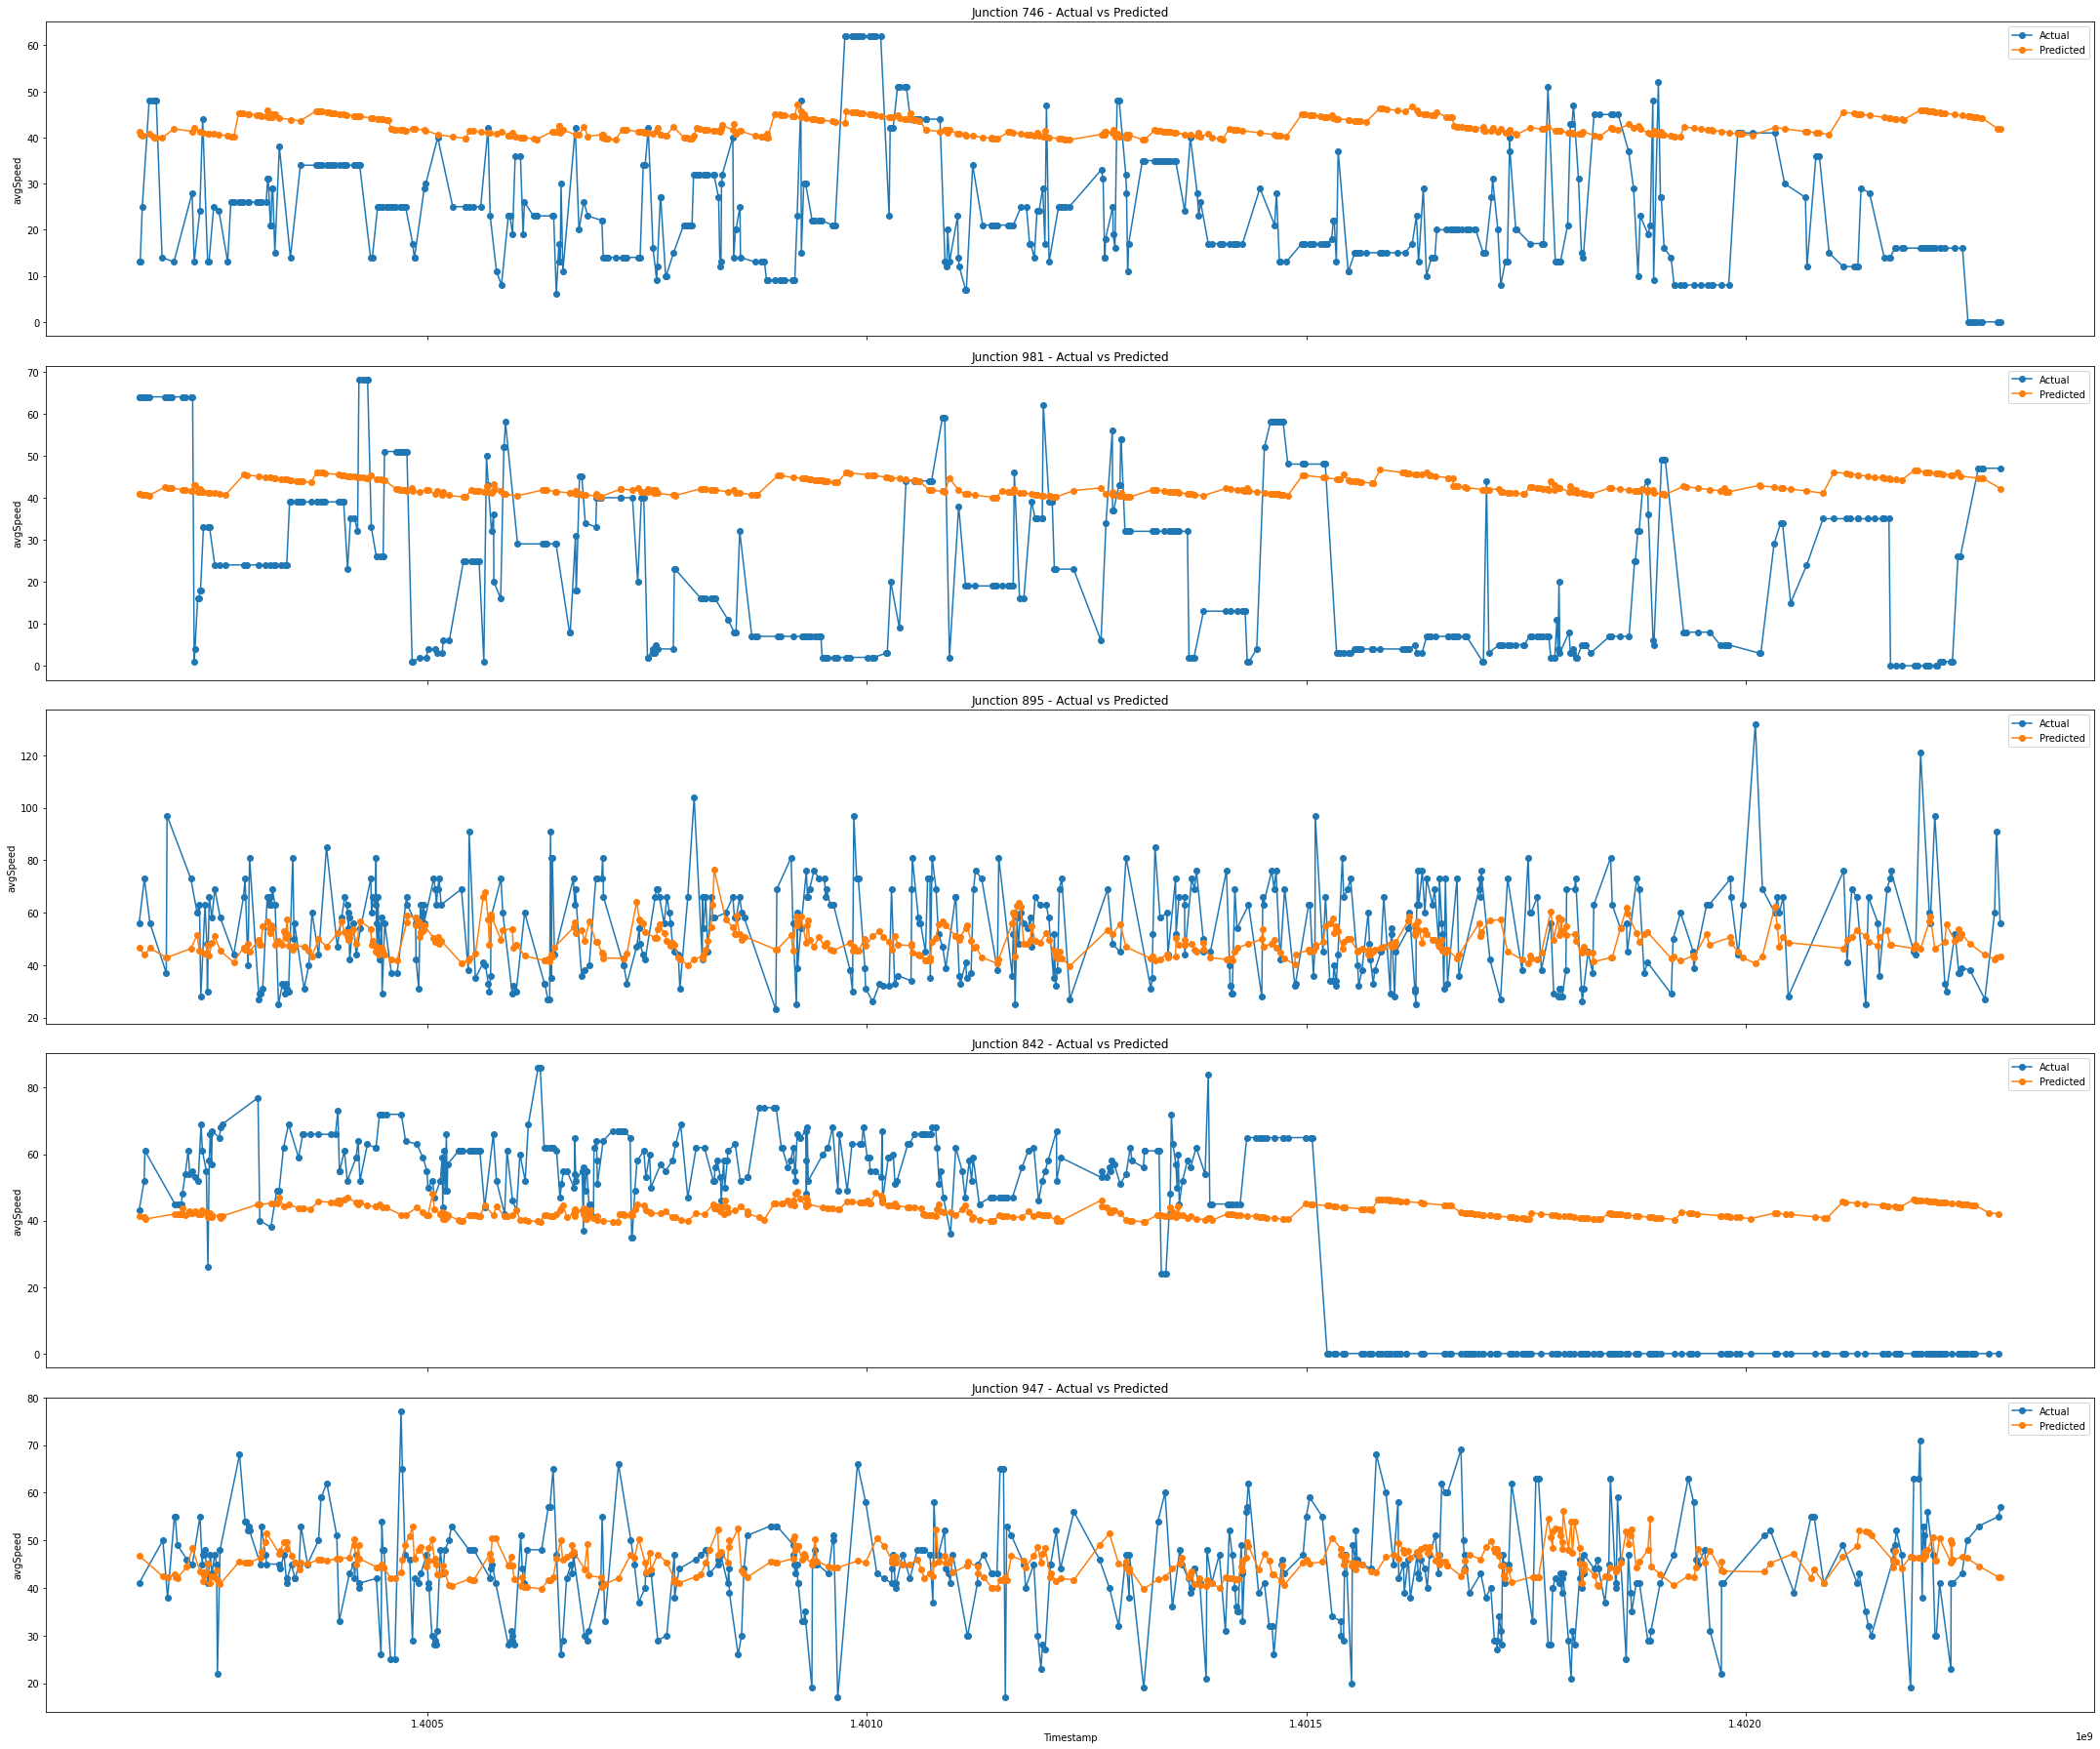

In [18]:
selected_junctions = X_test['junction'].unique()[:5]

# Create subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(30, 25), sharex=True)

for i, junction in enumerate(selected_junctions):
    # Filter data for the specific junction
    junction_data = X_test[X_test['junction'] == junction]
    
    # Make predictions for the junction
    junction_predictions = model.predict(junction_data)
    
    # Plot actual vs predicted values
    axes[i].plot(junction_data['unix'], y_test[junction_data.index], label='Actual', marker='o')
    axes[i].plot(junction_data['unix'], junction_predictions, label='Predicted', marker='o')
    
    # Set plot labels and title
    axes[i].set_title(f'Junction {junction} - Actual vs Predicted')
    axes[i].set_ylabel('avgSpeed')
    axes[i].legend()

# Set common x-axis label
axes[-1].set_xlabel('Timestamp')

# Adjust layout
plt.tight_layout()

plt.savefig('images/5_junction_avgSpeed_prediction_vs_actual.png', bbox_inches='tight')

# Show the plot
plt.show()

In [40]:
# alternative method for linear regression, very similar to lab assignment

# Select features and target variable for training
# X_train = df[['vehicleCount', 'Year', 'Month', 'Date_no', 'Hour', 'Day', 'unix', 'junction']]
# X_train = pd.get_dummies(X_train, columns=['Day'], drop_first=True) # one-hot encode 'Day' column

X_train = df[['vehicleCount', 'unix', 'junction']]
y_train = df['avgSpeed']

In [41]:
ph = 300
ph_index = round(ph/60)
mu = 0.9

n_s = 1000

#arrays to hold predicted values
tp_pred = np.zeros(n_s-31)
yp_pred = np.zeros(n_s-31)

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

for i in range(32, n_s + 1):
    ts_tmp = X_train.iloc[30:i, :]

    # Scale the features
    ts_tmp_scaled = scaler.fit_transform(ts_tmp)

    ys_tmp = y_train.iloc[30+ph_index-1:ph_index-1+i]
    ns = len(ys_tmp)

    weights = np.ones(ns) * mu

    for k in range(ns):
        weights[k] = weights[k] ** k
    weights = np.flip(weights, 0)

    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp_scaled, ys_tmp, sample_weight=weights)

    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    # print(f'Coefficients: {m_tmp}, Intercept: {q_tmp}')

    vehicleCount = X_train.iloc[i, 0]
    unix = X_train.iloc[i, 1]
    junction = X_train.iloc[i, 2]

    yp = m_tmp[0] * vehicleCount + m_tmp[1] * unix + m_tmp[2] * junction + q_tmp

    tp_pred[i-32] = unix + ph
    yp_pred[i-32] = yp


Coefficients: [-3.  3. -3.], Intercept: 65.0
Coefficients: [-9.2259104   1.04230145 -5.0440808 ], Intercept: 59.333333333333336
Coefficients: [-13.26648189  14.95902643  11.07862166], Intercept: 58.24999999999999
Coefficients: [-9.9728641   9.2197086   6.07133602], Intercept: 59.57461800088897
Coefficients: [-11.83210817   2.82524446   0.44142257], Intercept: 55.11319279068981
Coefficients: [-9.91985722 -2.38073182 -5.89410361], Intercept: 53.03654073169177
Coefficients: [-8.37303173 -4.16336351 -7.23401136], Intercept: 50.83229011285772
Coefficients: [-5.9804697  -1.1615657  -2.00582457], Intercept: 50.95682390769865
Coefficients: [-7.142525    3.83960194  5.49607261], Intercept: 56.574211866750524
Coefficients: [-7.50630561  0.83916722 -0.28880326], Intercept: 52.811677684149174
Coefficients: [-7.07961406  0.61583635 -0.47384694], Intercept: 53.09326575774773
Coefficients: [-6.76657495  0.58100476  0.10047531], Intercept: 52.73174697148317
Coefficients: [-6.16773097  1.17041261  7.23

Coefficients: [-0.59890911 32.60377101 -0.88417365], Intercept: -15.77860082021867


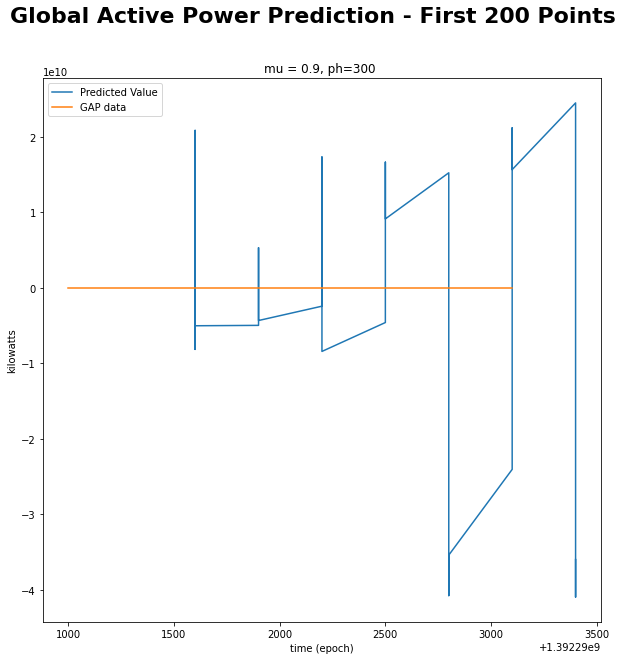

In [45]:
import matplotlib.pyplot as plt

# Plot first 200 data points/predictions for a moving average
fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle('Global Active Power Prediction - First 200 Points', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' % (mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
ax.plot(X_train.iloc[30:230, 1], y_train.iloc[30:230], label='GAP data')  # Assuming 'unix' is the timestamp column
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

# Print coefficients
print(f'Coefficients: {m_tmp}, Intercept: {q_tmp}')

plt.show()

In [47]:
# Assuming df is your training dataset
# Select relevant features and target variable
X_train = df[['vehicleCount', 'unix', 'junction']]
y_train = df['avgSpeed']

# Assuming df_test is your testing dataset
# Select relevant features and target variable
X_test = df_test[['vehicleCount', 'unix', 'junction']]
y_test = df_test['avgSpeed']

# Feature scaling (Optional, but recommended)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
predictions = model.predict(X_test_scaled)

# Evaluate the model
mse = mse(y_test, predictions)
print(f'Mean Squared Error on Test Data: {mse}')

# Now, let's randomly select a junction from the test set
random_junction = np.random.choice(X_test['junction'].unique())

# Filter data for the random junction
random_junction_data = X_test[X_test['junction'] == random_junction]
random_junction_predictions = model.predict(scaler.transform(random_junction_data[['vehicleCount', 'unix', 'junction']]))

# Print or use random_junction_predictions as needed
print(f'Predictions for Random Junction ({random_junction}): {random_junction_predictions}')


Mean Squared Error on Test Data: 479.8990115300569
Predictions for Random Junction (789): [44.00394522 42.12520247 42.75209641 42.12930097 42.13075528 42.13159261
 42.13172482 42.7587069  42.76121889 44.01505084 44.01513898 43.38895016
 42.76254098 44.01566782 43.38921458 42.76337831 42.13710135 42.76399529
 42.13798275 43.39221133 42.13978961 42.1418609  42.76937182 42.14349149
 42.14481358 42.77170753 44.02584797 42.77285334 45.27915108 43.40195078
 42.15014604 42.15217326 42.77884685 42.15248175 42.15296652 42.77999267
 42.15415641 42.15424455 42.15530223 42.15539037 42.15649211 42.15728537
 42.15759386 43.41120546 43.41252756 42.16116352 42.1617805  43.41561246
 42.78920328 42.78968805 42.16319074 43.41658199 42.16380772 42.16407214
 42.79242039 42.79378656 42.16733331 42.16742145 42.16755366 42.1680825
 42.79471202 42.79581377 43.42275178 42.17099112 43.4269825  42.80238019
 42.80242426 42.17667614 42.17676428 42.17698463 42.17962882 42.18055429
 42.18077464 42.80740416 42.8076245

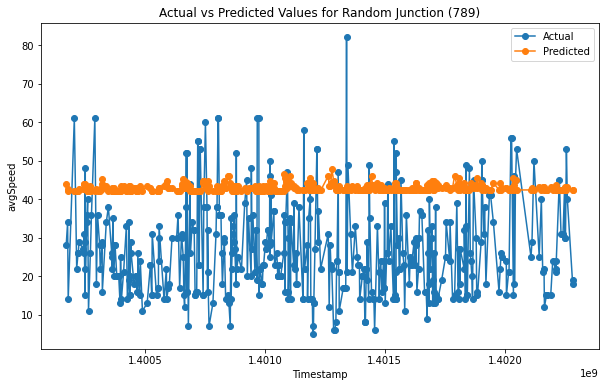

In [48]:
#  Assuming you have already trained the model and made predictions for a random junction
# random_junction_data and random_junction_predictions are assumed to be available

# Plot actual vs predicted values for the random junction
plt.figure(figsize=(10, 6))
plt.plot(random_junction_data['unix'], y_test[random_junction_data.index], label='Actual', marker='o')
plt.plot(random_junction_data['unix'], random_junction_predictions, label='Predicted', marker='o')

# Set plot labels and title
plt.title(f'Actual vs Predicted Values for Random Junction ({random_junction})')
plt.xlabel('Timestamp')
plt.ylabel('avgSpeed')
plt.legend()
plt.show()


In [67]:
# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

# Save the DataFrame to a CSV file
results_df.to_csv('predictions.csv', index=False)

# Display the DataFrame
results_df.head()

Actual  Predicted
0      13   40.99414
1      64   40.62891
2      56   46.51758
3      43   41.11719
4      41   46.58398

In [68]:
results_df.describe(include='all')

Actual             Predicted
count 200000.00000          200000.00000
mean      43.59878  -3494608733963.75684
std       22.22270   5419157904668.78809
min        0.00000 -11898160546103.71484
25%       29.00000 -11898160546096.33789
50%       42.00000              41.40820
75%       57.00000              44.42188
max      149.00000             106.67969